# Merging Excel Files

In [1]:
import os
import numpy as np
import pandas as pd
import emot as e
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt 
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from gensim.models import LdaModel, CoherenceModel
from pprint import pprint
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, ensemble

import warnings
warnings.filterwarnings('ignore')

e:\mscds\disertation\the_jup\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
os.chdir('E:\\MScDS\\Disertation\\Data')


# Merging files

In [3]:
df2 = pd.read_pickle('my_df.pickle')

# Exploratory Data Analysis

In [4]:
df2.head()

,Unnamed: 0,created_at,username,description,tweetid,mentions,location,following,followers,totaltweets,retweetcount,text,hashtags
48,48,2021-07-14 11:43:19,jesus_reigns247,"Lover of Truth, seeker of wisdom, Christ's bon...",1350632570183008257,[],NaN,172,31,424,0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,"['COVID19', 'CovidVaccine', 'tyrants', 'vaccin..."
422,422,2021-07-14 03:17:43,AllisonJanel,Conservative in California. Mama 🐻 to 2 babies...,358589571,[],LA County / California,1346,791,4170,0,Here in CA the government is literally offerin...,['CovidVaccine']
720,720,2021-07-13 19:18:35,kevojms,Values humanity with care especially the silen...,71753501,[],Dublin,505,763,8271,0,"Nice to see my friend John, pushing boxes at t...","['CovidVaccine', 'EUDigitalCovidCertificate']"
1995,1995,2021-07-12 20:14:43,TribuneCeylon,Welcome to https://t.co/tvL0EM4Yiz on Facebook...,1386694554540142595,[],NaN,18,9,1352,0,Online portal introduced for Covid vaccine app...,"['lka', 'news', 'srilanka', 'ceylontribune', '..."
327,327,2021-07-13 21:14:35,KerynCurtis,Writer/editor/communications/policy/campaigner...,27598939,"['DeborahSnow', 'johncollee', 'nickzwar']",Australia,2139,1517,2461,0,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,"['BastilleDay', 'COVIDVaccination', 'GetVaccin..."


In [5]:
df2.dtypes

Unnamed: 0               int64
created_at      datetime64[ns]
username                object
description             object
tweetid                  int64
mentions                object
location                object
following                int64
followers                int64
totaltweets              int64
retweetcount             int64
text                    object
hashtags                object
dtype: object

In [6]:
df2['date'] = df2.created_at.dt.date

In [7]:
df2['date'] = pd.to_datetime(df2['date'])

In [8]:
df2 = df2.sort_values(by = ['date'], axis = 0)

In [9]:
date_counts = pd.DataFrame(df2.date.value_counts())

In [10]:
date_counts

,date
2021-07-16,2982
2021-06-29,2760
2021-06-30,2389
2021-06-28,2307
2021-07-02,2227
2021-07-17,2225
2021-07-06,2014
2021-07-05,1917
2021-07-08,1839
2021-07-09,1805


In [49]:
date_counts.to_excel("EDA/date_counts.xlsx")

In [11]:
df2['time'] = df2.created_at.dt.time
df2['hour'] = df2.created_at.dt.hour

In [12]:
time_counts = pd.DataFrame(df2['hour'].value_counts())

In [13]:
time_counts

,hour
14,2471
15,2466
13,2385
16,2303
12,2195
17,2171
18,1978
11,1928
19,1870
9,1793


In [72]:
time_counts.to_excel("EDA/time_counts.xlsx")

In [76]:
sub_df2 = df2[['followers','following','totaltweets','text']]

In [84]:
sub_df2['len_text'] = sub_df2['text'].apply(len)

In [97]:
followers = df2.loc[df2['followers'].between(0, 20000),'followers']

In [108]:
labels = ['0-2000', "2001-4000", '4001-6000', '6001-8000', '8001-10000','10001-12000', "12001-14000", '14001-16000', '16001-18000', '18001-20000']
followers = pd.DataFrame(pd.cut(followers,10, labels = labels).value_counts())

In [111]:
followers

,followers
0-2000,32281
2001-4000,3449
4001-6000,1514
6001-8000,806
8001-10000,516
10001-12000,371
12001-14000,274
14001-16000,222
16001-18000,174
18001-20000,111


In [115]:
followers.to_excel('EDA/followers.xlsx')

In [116]:
df2['following'].describe()

count    4.118900e+04
mean     1.486941e+03
std      1.126117e+04
min      0.000000e+00
25%      1.760000e+02
50%      5.250000e+02
75%      1.361000e+03
max      2.033420e+06
Name: following, dtype: float64

In [121]:
following = df2.loc[df2['following'].between(0, 5000),'following']

In [122]:
labels = ['0-500', "501-1000", '1001-1500', '1501-2000', '2001-2500','2501-3000', "3001-3500", '3501-4000', '4001-4500', '4501-5000']
following = pd.DataFrame(pd.cut(following,10, labels = labels).value_counts())

In [125]:
following

,following
0-500,20072
501-1000,7833
1001-1500,3865
1501-2000,2379
2001-2500,1540
2501-3000,994
4501-5000,946
3001-3500,730
3501-4000,576
4001-4500,489


In [126]:
following.to_excel('EDA/following.xlsx')

In [134]:
totaltweets = df2.loc[df2['totaltweets'].between(0, 100000),'totaltweets']

In [136]:
totaltweets.head()

13675     177
13695    2066
13696    4395
13697     943
13698    3531
Name: totaltweets, dtype: int64

In [137]:
labels = ['0-10K', "10K-20K", '20K-30K', '30K-40K', '40K-50K','50K-60K', "60K-70K", '70K-80K', '80K-90K', '90K-100K']
totaltweets = pd.DataFrame(pd.cut(totaltweets,10, labels = labels).value_counts())

In [138]:

totaltweets


,totaltweets
0-10K,27549
10K-20K,5268
20K-30K,2431
30K-40K,1546
40K-50K,931
50K-60K,677
60K-70K,531
70K-80K,362
80K-90K,272
90K-100K,209


In [139]:
totaltweets.to_excel('EDA/totaltweets.xlsx')

In [14]:
hash = pd.DataFrame()

#https://ourcodingclub.github.io/tutorials/topic-modelling-python/
hash['hashtags'] = df2.hashtags.str[1:-1].str.split(',').tolist()

In [15]:
def remove_quotes(list):
    new = []
    for i in list:
        new.append(i.replace('\'',''))
    return new

In [16]:
hash['hashtags'] = hash['hashtags'].apply(remove_quotes)

In [17]:
hash['hashtags'].head()

0                                       [CovidVaccine]
1                                       [CovidVaccine]
2                                       [CovidVaccine]
3    [Liberty,  RLC,  Covid,  freedom,  BillofRight...
4                      [COVIDvaccine,  COVIranBarekat]
Name: hashtags, dtype: object

In [18]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hash.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [19]:
flattened_hashtags_df.head() 

,hashtag
0,CovidVaccine
1,CovidVaccine
2,CovidVaccine
3,Liberty
4,RLC


In [20]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

28180

In [21]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [24]:
popular_hashtags.head()

,hashtag,counts
0,vaccinated,7110
1,CovidVaccine,7031
2,vaccinated,6273
3,CovidVaccine,5442
4,COVID19,4514


In [25]:
popular_hashtags.to_excel('EDA/hashtags.xlsx')

In [26]:
mentions = pd.DataFrame()

#https://ourcodingclub.github.io/tutorials/topic-modelling-python/
mentions['mentions'] = df2.mentions.str[1:-1].str.split(',').tolist()

In [27]:
mentions['mentions'] = mentions['mentions'].apply(remove_quotes)

In [28]:
mentions.head()

,mentions
0,[]
1,[]
2,[]
3,"[congbillposey, RepThomasMassie]"
4,[]


In [29]:
flattened_mentions_df = pd.DataFrame(
    [mentions for mentions_list in mentions.mentions
    for mentions in mentions_list],
    columns=['mentions'])

In [30]:
flattened_mentions_df.head()

,mentions
0,
1,
2,
3,congbillposey
4,RepThomasMassie


In [31]:
# number of unique mention
flattened_mentions_df['mentions'].unique().size

15512

In [32]:
# count of appearances of each mention
popular_mentions = flattened_mentions_df.groupby('mentions').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

In [34]:
popular_mentions[1:]

,mentions,counts
1,EU_Commission,255
2,SecBlinken,249
3,UNHumanRights,248
4,JosepBorrellF,247
5,NATO,247
...,...,...
15507,amerix,1
15508,amirkingkhan,1
15509,amitabhk87,1
15510,amitsurg,1


In [35]:
popular_mentions.to_excel('EDA/mentions.xlsx')

In [37]:
df2['len_text']= df2['text'].apply(len)

In [39]:
df2['len_text'].describe()

count    41189.000000
mean       178.946661
std         80.929980
min         16.000000
25%        110.000000
50%        176.000000
75%        254.000000
max        996.000000
Name: len_text, dtype: float64

In [40]:
df2['len_text'].to_excel('EDA/len_text.xlsx')

In [4]:
from geopy.geocoders import Nominatim

In [24]:
location = pd.DataFrame(df2['location'])

In [25]:
location.reset_index(drop = True, inplace = True)

In [26]:
location.dropna(inplace = True)

In [27]:
location = pd.DataFrame(location['location'].replace('nan', np.nan, regex=True))

In [28]:
location['location'].reset_index(drop = True, inplace = True)

In [32]:
location.isna().sum()

location      54
lat         3467
long        3467
dtype: int64

In [33]:
location.head()

,location,lat,long
1,LA County / California,7.346434,-72.951890
2,Dublin,53.349764,-6.260273
4,Australia,-24.776109,134.755000
5,"Leeds, England",53.797418,-1.543794
7,India,22.351115,78.667743


In [34]:
location.to_excel('EDA/location.xlsx')

# Preprocessing

In [8]:
#Drop Unnamed Column
df2.drop('Unnamed: 0',1, inplace = True)

In [9]:
df2.isnull().sum()

created_at         0
username           0
description     2863
tweetid            0
mentions           0
location        9191
following          0
followers          0
totaltweets        0
retweetcount       0
text               0
hashtags           0
date               0
dtype: int64

In [10]:
df2 = df2.reset_index(drop=True)

In [11]:
df2.loc[3,'text']

'Online portal introduced for Covid vaccine appointments in WP\nhttps://t.co/x5E90onulZ\n#lka #news #srilanka #ceylontribune #OnlinePortal #Introduced #CovidVaccine #Appointments #WesternProvince #covid19LK'

# Handling Emojis

In [12]:
df2['text'][41185]

'In fact, they may already have sterilized her AND HER WHOLE FAMILY🤔😂🤣 #VaccinesWork #eugenics'

In [13]:
#Extracting meaning from emoji
def emoji(text):
    emoji = e.emoji(text)['mean']
    if len(emoji) == 0:
        return ''
    elif len(emoji) >= 0:
        chars = ''
        for i in range(len(emoji)):
            chars = chars + ' ' + re.sub(r'_'," ",re.sub(r'\:', "",emoji[i]))
        return chars

In [14]:
df2['emoji'] = df2['text'].apply(emoji)

In [15]:
df2.emoji[41185]

' thinking face face with tears of joy rolling on the floor laughing'

In [16]:
df2.shape

(41189, 14)

In [17]:
df2['emoji'].tail()

41184                                                     
41185     thinking face face with tears of joy rolling ...
41186                        person bowing light skin tone
41187                                                     
41188                                                     
Name: emoji, dtype: object

In [18]:
text_df = pd.DataFrame()
text_df['text_original'] = df2['text']
text_df['emoji'] = df2['emoji']

In [19]:
text_df.tail()

,text_original,emoji
41184,via @NYTOpinion ⁦@US_FDA⁩ SO important! Daily ...,
41185,"In fact, they may already have sterilized her ...",thinking face face with tears of joy rolling ...
41186,Alhamdulillah got my #2nddose appointment date...,person bowing light skin tone
41187,@angie_rasmussen @DrLeanaWen @JWhitePubRadio @...,
41188,Communities of color are getting vaccinated at...,


# Cleaning Tweets

In [20]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+',"",text)
    text = re.sub(r'#[A-Za-z0-9]+','',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoj, '', text)
    return text

In [21]:
text_df['tweet'] = text_df['text_original'].apply(cleantext)

In [22]:
text_df['tweet'][41185]

'In fact, they may already have sterilized her AND HER WHOLE FAMILY  '

In [23]:
def text_preprocessing(text): 
    text = text.lower()
    text_p = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text_p)
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]
    str1 = ' '.join(filtered_words)
    return str1

In [24]:
text_df['tweet'][101]

' newly discovered side effects… Now people told  children. Don’t understand as rarely hear kids infected? \n\nJ&amp;J’s Covid-19 vaccine may trigger neurological condition in rare cases, FDA says  via '

In [26]:
text_df['clean_tweet'] = text_df['tweet'].apply(text_preprocessing)

In [27]:
text_df['clean_tweet'][101]

'newly discovered side effects… people told children ’ understand rarely hear kids infected jampj ’ covid19 vaccine may trigger neurological condition rare cases fda says via'

In [28]:
text_df.head()

,text_original,emoji,tweet,clean_tweet
0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,,In my cold dead arm\n will never be in my bod...,cold dead arm never body stop govt overreach p...
1,Here in CA the government is literally offerin...,,Here in CA the government is literally offerin...,ca government literally offering free weed get...
2,"Nice to see my friend John, pushing boxes at t...",,"Nice to see my friend John, pushing boxes at t...",nice see friend john pushing boxes start hard ...
3,Online portal introduced for Covid vaccine app...,,Online portal introduced for Covid vaccine app...,online portal introduced covid vaccine appoint...
4,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,,It’s &amp; I celebrate by sharing this fabul...,’ amp celebrate sharing fabulous french vaccin...


# Most Frequent Words

In [29]:
words = text_df['clean_tweet'].apply(word_tokenize)

In [30]:
word = []
for i in range(len(words)):
    word = word + words[i] 

In [31]:
len(word)
print(type(word))

<class 'list'>


In [32]:
[word for word in text_df['clean_tweet'][0].split()]

['cold',
 'dead',
 'arm',
 'never',
 'body',
 'stop',
 'govt',
 'overreach',
 'poison',
 'authoritarian',
 'ruler']

In [33]:
from nltk.probability import FreqDist
fdist = FreqDist(word)
most_common = fdist.most_common(50)

In [34]:
most_common_stop = []
for i in most_common:
    most_common_stop.append(i[0])
    

# Tokenization

In [35]:
nlp = spacy.load('en_core_web_sm')

In [36]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [37]:
tokens = []

for doc in tokenizer.pipe(text_df['clean_tweet'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in most_common_stop:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
text_df['tokens'] = tokens

In [38]:
text_df['tokens']

0        [cold, dead, arm, never, body, stop, govt, ove...
1        [ca, government, literally, offering, free, we...
2        [nice, see, friend, john, pushing, boxes, star...
3           [online, portal, introduced, appointments, wp]
4               [celebrate, sharing, fabulous, french, ad]
                               ...                        
41184    [via, ⁦fda⁩, important, daily, patients, tell,...
41185      [fact, may, already, sterilized, whole, family]
41186    [alhamdulillah, appointment, date, nine, weeks...
41187    [rasmussen, awesome, show, thx, evidencebased,...
41188    [communities, color, lower, rates, white, coun...
Name: tokens, Length: 41189, dtype: object

In [39]:
# Make tokens a string again
text_df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in text_df['tokens']]

In [40]:
text_df['clean_tweet'][500]

'oh glad hear shes feeling sick'

In [41]:
text_df['tokens'][500]

['oh', 'glad', 'hear', 'shes', 'feeling', 'sick']

In [42]:
text_df['tokens_back_to_text'][500]


'oh glad hear shes feeling sick'

In [43]:
text_df.head()

,text_original,emoji,tweet,clean_tweet,tokens,tokens_back_to_text
0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,,In my cold dead arm\n will never be in my bod...,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...
1,Here in CA the government is literally offerin...,,Here in CA the government is literally offerin...,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...
2,"Nice to see my friend John, pushing boxes at t...",,"Nice to see my friend John, pushing boxes at t...",nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...
3,Online portal introduced for Covid vaccine app...,,Online portal introduced for Covid vaccine app...,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp
4,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,,It’s &amp; I celebrate by sharing this fabul...,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad


# Lemmetization

In [44]:
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

text_df['lemmas'] = text_df['tokens_back_to_text'].apply(get_lemmas)


In [45]:
text_df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in text_df['lemmas']]

In [46]:
# Tokenizer functions
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    text = ' '.join([w for w in text.split() if len(w)>3])
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE
    
    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
text_df['lemma_tokens'] = text_df['lemmas_back_to_text'].apply(tokenize)

In [47]:
text_df['lemma_tokens'][3]

['online', 'portal', 'introduce', 'appointment']

In [48]:
text_df.head()

,text_original,emoji,tweet,clean_tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,,In my cold dead arm\n will never be in my bod...,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...,"[cold, dead, arm, body, stop, govt, overreach,...",cold dead arm body stop govt overreach poison ...,"[cold, dead, body, stop, govt, overreach, pois..."
1,Here in CA the government is literally offerin...,,Here in CA the government is literally offerin...,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...,"[government, literally, offer, free, weed, pre...",government literally offer free weed pretend,"[government, literally, offer, free, weed, pre..."
2,"Nice to see my friend John, pushing boxes at t...",,"Nice to see my friend John, pushing boxes at t...",nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...,"[nice, friend, john, pushing, box, start, hard...",nice friend john pushing box start hard work e...,"[nice, friend, john, pushing, start, hard, wor..."
3,Online portal introduced for Covid vaccine app...,,Online portal introduced for Covid vaccine app...,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp,"[online, portal, introduce, appointment, wp]",online portal introduce appointment wp,"[online, portal, introduce, appointment]"
4,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,,It’s &amp; I celebrate by sharing this fabul...,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad,"[celebrate, share, fabulous, french, ad]",celebrate share fabulous french ad,"[celebrate, share, fabulous, french]"


# Model with BoW

In [49]:
# Create a id2word dictionary
id2word = Dictionary(text_df['lemma_tokens'])
print(len(id2word))

27651


In [50]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

10817


In [51]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in text_df['lemma_tokens']]

In [86]:
MulLda_coherent_scores = []
MulLda_topics_val = []
MulLda_perplexity_val = []
alpha_val = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
MulLda_alphas = []


for topics in range(7, 13, 2):
    print(topics)
    for alph in alpha_val:
        print(alph)

        lda_model_multi_notts = gensim.models.LdaMulticore(corpus = corpus,
                     id2word = id2word,
                     random_state = 42,
                     num_topics = topics,
                     passes=10,
                     chunksize=512,
                     alpha=alph,
                     offset=64,
                     eta=None,
                     iterations=100,
                     per_word_topics=True,
                     workers=6)

        coherence_model_MulLda_notts = CoherenceModel(model = lda_model_multi_notts, 
                                   texts = text_df['lemma_tokens'], 
                                   dictionary = id2word, 
                                   coherence = 'c_v')

        coherence_MulLda = coherence_model_MulLda_notts.get_coherence()
        perplexity_MulLda = lda_model_multi_notts.log_perplexity(corpus)

        MulLda_topics_val.append(topics)
        MulLda_alphas.append(alph)        
        MulLda_coherent_scores.append(coherence_MulLda)
        MulLda_perplexity_val.append(perplexity_MulLda)
            

            
df_mulLDA_notts = pd.DataFrame(list(zip(MulLda_topics_val, MulLda_alphas, MulLda_coherent_scores, MulLda_perplexity_val)), 
                         columns = ["MulLda_Topic_Num", "MulLda_alpha_val", "MulLda_Coherent_score", "MulLda_Perplexity_val"])

df_mulLDA_notts.sort_values("MulLda_Coherent_score", axis = 0, ascending = False, 
                     inplace = True) 

df_mulLDA_notts.head()

7
0.05
0.1
0.3
0.5
0.8
1
9
0.05
0.1
0.3
0.5
0.8
1
11
0.05
0.1
0.3
0.5
0.8
1


,MulLda_Topic_Num,MulLda_alpha_val,MulLda_Coherent_score,MulLda_Perplexity_val
6,9,0.05,0.368453,-8.070022
12,11,0.05,0.349216,-8.101546
7,9,0.10,0.340201,-8.050964
13,11,0.10,0.335908,-8.076597
14,11,0.30,0.334519,-8.033728


In [52]:
multi_lda_final_notts = gensim.models.LdaMulticore(corpus = corpus,
                         id2word = id2word,
                         random_state = 42,
                         num_topics = 9,
                         passes=10,
                         chunksize=512,
                         alpha=0.05,
                         offset=64,
                         eta=None,
                         iterations=100,
                         per_word_topics=True,
                         workers=6)

pprint(multi_lda_final_notts.print_topics(num_topics = 9, num_words=20))

print("\n\033[91m" + "\033[1m" +"------- Visualization -----------\n")

lda_Mul_vis_notts = gensimvis.prepare(multi_lda_final_notts, corpus, id2word)
pyLDAvis.display(lda_Mul_vis_notts)

[(0,
  '0.031*"wait" + 0.026*"double" + 0.020*"thank" + 0.016*"jabbed" + '
  '0.013*"staff" + 0.009*"great" + 0.008*"volunteer" + 0.008*"week" + '
  '0.008*"summer" + 0.007*"look" + 0.007*"queue" + 0.007*"team" + '
  '0.007*"super" + 0.006*"amazing" + 0.006*"soon" + 0.006*"girl" + '
  '0.006*"finally" + 0.006*"minute" + 0.006*"long" + 0.005*"announce"'),
 (1,
  '0.040*"mask" + 0.028*"wear" + 0.010*"public" + 0.010*"continue" + '
  '0.009*"2021" + 0.009*"follow" + 0.008*"july" + 0.007*"state" + 0.007*"stay" '
  '+ 0.006*"news" + 0.006*"student" + 0.006*"drive" + 0.006*"slot" + '
  '0.005*"require" + 0.005*"social" + 0.005*"protect" + 0.005*"indoor" + '
  '0.005*"officially" + 0.005*"order" + 0.005*"service"'),
 (2,
  '0.023*"week" + 0.023*"book" + 0.021*"appointment" + 0.021*"clinic" + '
  '0.017*"july" + 0.017*"centre" + 0.015*"receive" + 0.013*"visit" + '
  '0.013*"available" + 0.012*"walkin" + 0.011*"weekend" + 0.010*"walk" + '
  '0.010*"find" + 0.010*"tomorrow" + 0.009*"come" + 0.00

In [53]:
pyLDAvis.save_html(lda_Mul_vis_notts, "Topic Modeling//Vaccs_topic_9.html")

In [54]:
topicss = []
probss = []

for i, row in enumerate(multi_lda_final_notts[corpus]):     # gives topics probablity

    row = sorted(row[0], key=lambda x :(x[1]), reverse=True)    # sorting according to higher probability
    for j, (topic_num, probablity) in enumerate(row):        # j=0  --> containing highest probablity, topic_num --> falls under which topic
        if j == 0:
            topicss.append(topic_num)
            probss.append(probablity)
            
text_df["Topic_Num"] = topicss
text_df["Topic_prob"] = probss

text_df.head()

,text_original,emoji,tweet,clean_tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,Topic_Num,Topic_prob
0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,,In my cold dead arm\n will never be in my bod...,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...,"[cold, dead, arm, body, stop, govt, overreach,...",cold dead arm body stop govt overreach poison ...,"[cold, dead, body, stop, govt, overreach, pois...",1,0.515597
1,Here in CA the government is literally offerin...,,Here in CA the government is literally offerin...,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...,"[government, literally, offer, free, weed, pre...",government literally offer free weed pretend,"[government, literally, offer, free, weed, pre...",2,0.505259
2,"Nice to see my friend John, pushing boxes at t...",,"Nice to see my friend John, pushing boxes at t...",nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...,"[nice, friend, john, pushing, box, start, hard...",nice friend john pushing box start hard work e...,"[nice, friend, john, pushing, start, hard, wor...",4,0.748023
3,Online portal introduced for Covid vaccine app...,,Online portal introduced for Covid vaccine app...,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp,"[online, portal, introduce, appointment, wp]",online portal introduce appointment wp,"[online, portal, introduce, appointment]",2,0.679962
4,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,,It’s &amp; I celebrate by sharing this fabul...,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad,"[celebrate, share, fabulous, french, ad]",celebrate share fabulous french ad,"[celebrate, share, fabulous, french]",2,0.498048


In [55]:
tpc_nms = []

for tpc_ in text_df["Topic_Num"].values.tolist():
    if tpc_ == 0:
        tpc_nms.append("Thank staff for double jab")
    if tpc_ == 1:
        tpc_nms.append("In 2021, continue to wear a mask in public")
    if tpc_ == 2:
        tpc_nms.append("Book appointments for vaccination in clinics or centres")
    if tpc_ == 3:
        tpc_nms.append("Delta variant cases lead to higher death rate")
    if tpc_ == 4:
        tpc_nms.append("Help and support healthcare workers")
    if tpc_ == 5:
        tpc_nms.append("Save the world by protecting families")
    if tpc_ == 6:
        tpc_nms.append("Take your vaccine and fight the disease")
    if tpc_ == 7:
        tpc_nms.append("Stay positive and test regularly")
    if tpc_ == 8:
        tpc_nms.append("Post vaccination there maybe side effects") 
        
text_df["Topic_Names"] = tpc_nms

In [56]:
text_df.columns

Index(['text_original', 'emoji', 'tweet', 'clean_tweet', 'tokens',
       'tokens_back_to_text', 'lemmas', 'lemmas_back_to_text', 'lemma_tokens',
       'Topic_Num', 'Topic_prob', 'Topic_Names'],
      dtype='object')

In [58]:
temp_df = pd.merge(text_df,df2, left_on = ['text_original','emoji'], right_on = ['text','emoji'])

In [59]:
text_df = temp_df[['text_original', 'emoji', 'tweet', 'clean_tweet', 'tokens',
       'tokens_back_to_text', 'lemmas', 'lemmas_back_to_text', 'lemma_tokens',
       'Topic_Num', 'Topic_prob', 'Topic_Names','date']]

In [60]:
text_df.head()

,text_original,emoji,tweet,clean_tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,Topic_Num,Topic_prob,Topic_Names,date
0,In my cold dead arm\n#COVID19 #CovidVaccine wi...,,In my cold dead arm\n will never be in my bod...,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...,"[cold, dead, arm, body, stop, govt, overreach,...",cold dead arm body stop govt overreach poison ...,"[cold, dead, body, stop, govt, overreach, pois...",1,0.515597,"In 2021, continue to wear a mask in public",2021-07-14
1,Here in CA the government is literally offerin...,,Here in CA the government is literally offerin...,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...,"[government, literally, offer, free, weed, pre...",government literally offer free weed pretend,"[government, literally, offer, free, weed, pre...",2,0.505259,Book appointments for vaccination in clinics o...,2021-07-14
2,"Nice to see my friend John, pushing boxes at t...",,"Nice to see my friend John, pushing boxes at t...",nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...,"[nice, friend, john, pushing, box, start, hard...",nice friend john pushing box start hard work e...,"[nice, friend, john, pushing, start, hard, wor...",4,0.748023,Help and support healthcare workers,2021-07-13
3,Online portal introduced for Covid vaccine app...,,Online portal introduced for Covid vaccine app...,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp,"[online, portal, introduce, appointment, wp]",online portal introduce appointment wp,"[online, portal, introduce, appointment]",2,0.679962,Book appointments for vaccination in clinics o...,2021-07-12
4,It’s #BastilleDay 🇫🇷 &amp; I celebrate by shar...,,It’s &amp; I celebrate by sharing this fabul...,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad,"[celebrate, share, fabulous, french, ad]",celebrate share fabulous french ad,"[celebrate, share, fabulous, french]",2,0.498048,Book appointments for vaccination in clinics o...,2021-07-13


 # Subjectivity and Polarity

In [61]:
text_df['polarity'] = text_df['lemmas_back_to_text'].apply(lambda x : TextBlob(x).sentiment.polarity)
text_df['subjectivity'] = text_df['lemmas_back_to_text'].apply(lambda x : TextBlob(x).sentiment.subjectivity)


In [62]:
text_df[['lemmas_back_to_text','subjectivity','polarity']].head()

,lemmas_back_to_text,subjectivity,polarity
0,cold dead arm body stop govt overreach poison ...,0.700000,-0.400000
1,government literally offer free weed pretend,0.800000,0.400000
2,nice friend john pushing box start hard work e...,0.513889,0.102778
3,online portal introduce appointment wp,0.000000,0.000000
4,celebrate share fabulous french ad,0.500000,0.200000


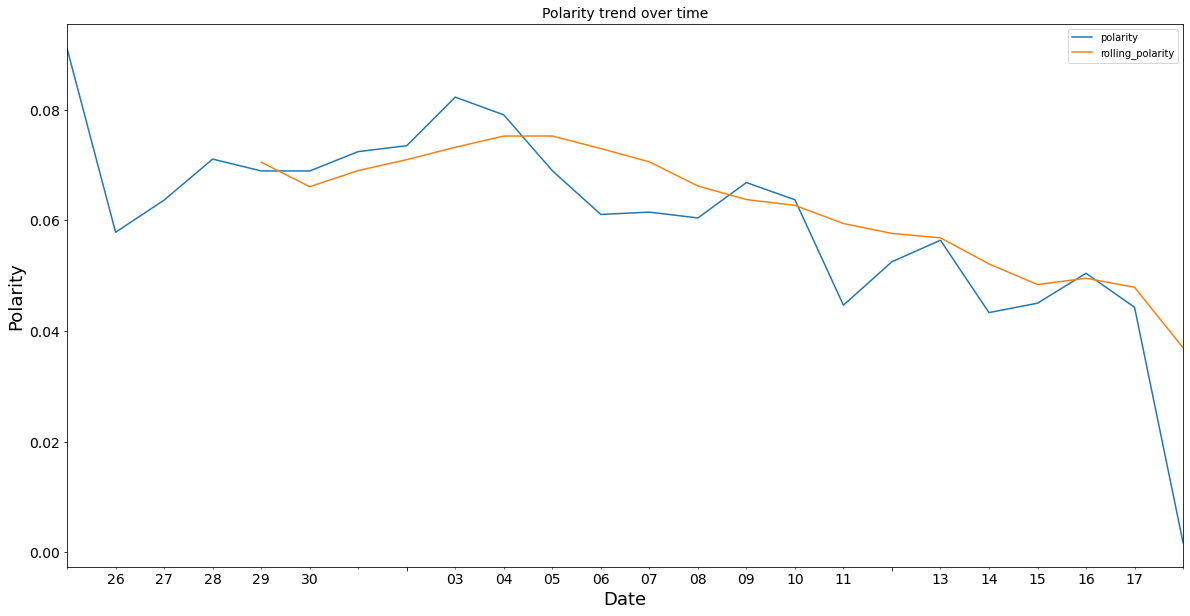

In [63]:
df = text_df[["date", "polarity", "subjectivity"]].groupby("date").mean().reset_index()
df['rolling_polarity'] = df.polarity.rolling(window=5).mean()
df['rolling_subjectivity'] = df.subjectivity.rolling(window=5).mean()
ax = df.plot(x="date", 
        y=["polarity", "rolling_polarity"], 
        figsize=(20, 10), 
        fontsize=14)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xlabel("Date", fontsize=18)
plt.ylabel("Polarity", fontsize=18)
plt.title("Polarity trend over time", fontsize=14)
plt.show()

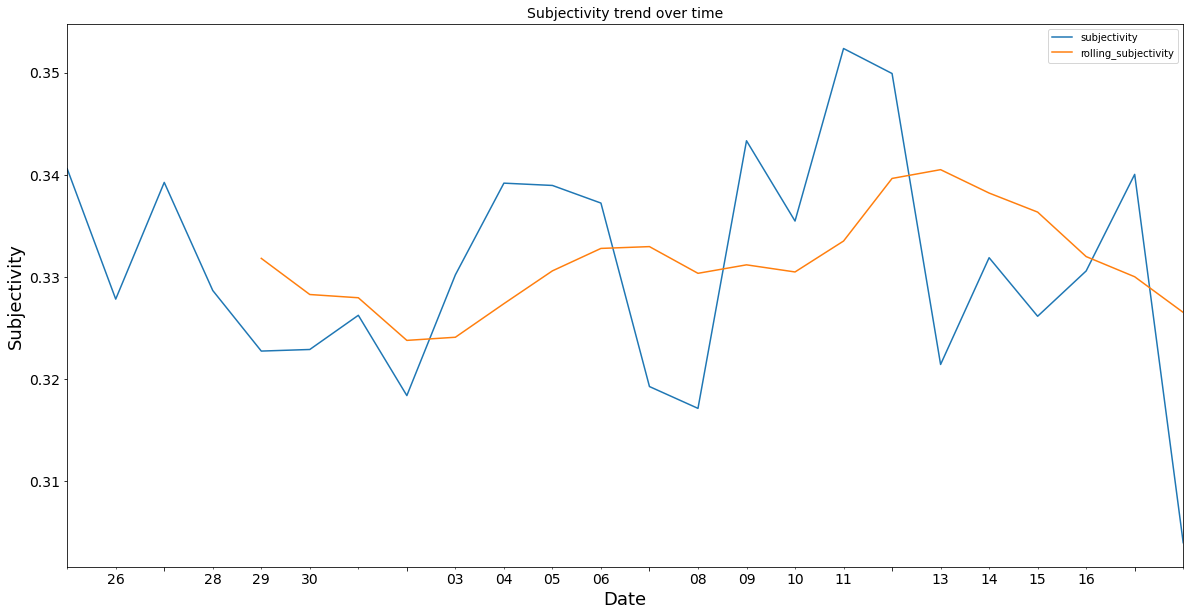

In [64]:
ax = df.plot(x="date", 
        y=["subjectivity", "rolling_subjectivity"], 
        figsize=(20, 10), 
        fontsize=14)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xlabel("Date", fontsize=18)
plt.ylabel("Subjectivity", fontsize=18)
plt.title("Subjectivity trend over time", fontsize=14)
plt.show()

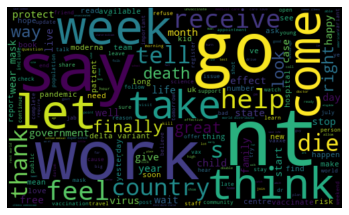

In [65]:
allWords = ' '.join([twts for twts in text_df['lemmas_back_to_text']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [84]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
text_df['Analysis'] = text_df['polarity'].apply(getAnalysis)

sample = text_df[['lemmas_back_to_text','subjectivity','polarity','Analysis','date']].head() # to_excel('Sentiment_Analysis\sent.xlsx')



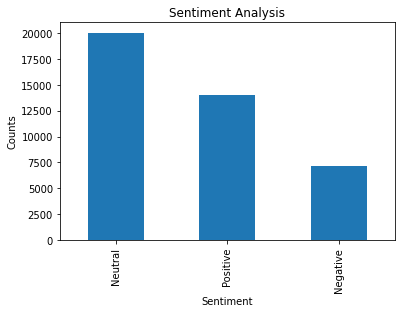

In [83]:
text_df['Analysis'].value_counts()

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
text_df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Text Classification

In [68]:
# Set the topic of interest for bianry classification
topic_of_interest = 6

# create a binary label where 1 is the topic of interest and 0 is the rest
text_df['label'] = np.where(text_df['Topic_Num'] == topic_of_interest, 1, 0)  
text_df['label'].value_counts()

0    37646
1     3543
Name: label, dtype: int64

In [69]:
# Spliting the data into train and test sets
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split

# cleaned body of documents
X = text_df['lemmas_back_to_text']  
# Target variable
y = text_df['label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [76]:
from sklearn.utils import resample

# concatenate our training data back together
train_concat = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
majority_class = train_concat[train_concat.label==0]
minority_class = train_concat[train_concat.label==1]

# upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True, # sample with replacement
                              n_samples=len(majority_class), # match number in majority class
                              random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([majority_class, minority_upsampled])

#shuffle 
upsampled = upsampled.sample(frac=1, random_state = 100).reset_index(drop=True)

y_train = upsampled['label']
X_train = upsampled['lemmas_back_to_text']

In [77]:
pipeline = Pipeline([
    ('vect',TfidfVectorizer(max_df = 0.6, min_df=0.0001, norm = 'l2', use_idf = True, ngram_range = (1,2), max_features = None)), 
    ('clf',SGDClassifier(random_state=0,  alpha = 2e-05, penalty = 'l2', loss = 'modified_huber', max_iter = 10)) 
])

In [115]:
parameters = {
    'vect__max_df': (0.6, 0.7, 0.8), # max threshold for document frequency
    'vect__min_df': (0.0001, 0.001),
    'vect__max_features': (None, 5000, 10000), # top max_features ordered by term frequency across the corpus
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True, False), # Enables inverse-document-frequency reweighting
    'vect__norm': (None, 'l1', 'l2'), # normalizes tf-idf in each row
    'clf__loss': ('log','modified_huber','hinge'), # log for logistic regression, modified_huber gives a smooth loss tolerant to outliers, hinge for linear SVM
    'clf__alpha': (0.00001,0.00002), # multiplies the regularization term
    'clf__penalty': ('none','l2','l1'), # regularization term
    'clf__max_iter': (10, 50), # passes over the training data (aka epochs)
}

In [117]:
# Grid search with cross validation
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='roc_auc', n_jobs=10, verbose=1) # 'roc_auc' or 'f1'

print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

# model training
grid_search.fit(X_train, y_train)


pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.6, 0.7, 0.8), 'vect__min_df': (0.0001, 0.001), 'vect__max_features': (None, 5000, 10000), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'vect__norm': (None, 'l1', 'l2'), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'clf__alpha': (1e-05, 2e-05), 'clf__penalty': ('none', 'l2', 'l1'), 'clf__max_iter': (10, 50)}
Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.8,
                                                        min_df=0.0001)),
                                       ('clf',
                                        SGDClassifier(alpha=2e-05,
                                                      random_state=0))]),
             n_jobs=10,
             param_grid={'clf__alpha': (1e-05, 2e-05),
                         'clf__loss': ('log', 'modified_huber', 'hinge'),
                         'clf__max_iter': (10, 50),
                         'clf__penalty': ('none', 'l2', 'l1'),
                         'vect__max_df': (0.6, 0.7, 0.8),
                         'vect__max_features': (None, 5000, 10000),
                         'vect__min_df': (0.0001, 0.001),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__norm': (None, 'l1', 'l2'),
                         'vec

In [118]:
### Result of grid search
print("Best score: %0.3f" % grid_search.best_score_)  
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.999
Best parameters set:
	clf__alpha: 2e-05
	clf__loss: 'modified_huber'
	clf__max_iter: 10
	clf__penalty: 'l2'
	vect__max_df: 0.6
	vect__max_features: None
	vect__min_df: 0.0001
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__use_idf: True


In [119]:
# best estimator found from grid search
model = grid_search.best_estimator_

In [120]:
# Model predictions

predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [121]:
# Return of the Accuracy, Precision, Recall, F1 Score, AUC score

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))
print("f1_score:",metrics.f1_score(y_test, predictions))
print('AUC: ', metrics.roc_auc_score(y_test, predictions))

Accuracy: 0.9501845018450185
Precision: 0.7585266030013642
Recall: 0.6233183856502242
f1_score: 0.6843076923076923
AUC:  0.8022503048812465


In [122]:
# confusion matrix of predictions

cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[9229,  177],
       [ 336,  556]], dtype=int64)

# Final Model

In [78]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.6, min_df=0.0001,
                                 ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(alpha=2e-05, loss='modified_huber', max_iter=10,
                               random_state=0))])

In [79]:
predictions = pipeline.predict(X_test)

In [80]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))
print("f1_score:",metrics.f1_score(y_test, predictions))
print('AUC: ', metrics.roc_auc_score(y_test, predictions))

Accuracy: 0.9502816080792387
Precision: 0.7547683923705722
Recall: 0.6252821670428894
f1_score: 0.6839506172839507
AUC:  0.8030788225779684


In [81]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[9232,  180],
       [ 332,  554]], dtype=int64)

# With Emoji and Text

In [134]:
emoji_df = pd.DataFrame()
emoji_df['emoji_with_clean_tweet'] = text_df['clean_tweet'] + text_df['emoji']

In [135]:
emoji_df.tail()

,emoji_with_clean_tweet
41184,via ⁦fda⁩ important daily patients tell highly...
41185,fact may already sterilized whole family think...
41186,alhamdulillah got appointment date nine weeks ...
41187,rasmussen awesome today ’ show thx evidencebas...
41188,communities color getting vaccinated lower rat...


# Tokenization

In [136]:
nlp = spacy.load('en_core_web_sm')

In [137]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [138]:
tokens = []

for doc in tokenizer.pipe(emoji_df['emoji_with_clean_tweet'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in most_common_stop:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
emoji_df['tokens'] = tokens

In [139]:
emoji_df['tokens']

0        [cold, dead, arm, never, body, stop, govt, ove...
1        [ca, government, literally, offering, free, we...
2        [nice, see, friend, john, pushing, boxes, star...
3           [online, portal, introduced, appointments, wp]
4               [celebrate, sharing, fabulous, french, ad]
                               ...                        
41184    [via, ⁦fda⁩, important, daily, patients, tell,...
41185    [fact, may, already, sterilized, whole, family...
41186    [alhamdulillah, appointment, date, nine, weeks...
41187    [rasmussen, awesome, show, thx, evidencebased,...
41188    [communities, color, lower, rates, white, coun...
Name: tokens, Length: 41189, dtype: object

In [140]:
# Make tokens a string again
emoji_df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in emoji_df['tokens']]

In [141]:
emoji_df['emoji_with_clean_tweet'][500]

'oh glad hear shes feeling sick'

In [142]:
emoji_df['tokens'][500]

['oh', 'glad', 'hear', 'shes', 'feeling', 'sick']

In [143]:
emoji_df['tokens_back_to_text'][500]

'oh glad hear shes feeling sick'

In [144]:
emoji_df.head()

,emoji_with_clean_tweet,tokens,tokens_back_to_text
0,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...
1,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...
2,nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...
3,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp
4,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad


# Lemmetization

In [145]:
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

emoji_df['lemmas'] = emoji_df['tokens_back_to_text'].apply(get_lemmas)


In [146]:
emoji_df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in emoji_df['lemmas']]

In [147]:
# Tokenizer functions
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    text = ' '.join([w for w in text.split() if len(w)>3])
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE
    
    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
emoji_df['lemma_tokens'] = emoji_df['lemmas_back_to_text'].apply(tokenize)

In [148]:
emoji_df['lemma_tokens'][3]

['online', 'portal', 'introduce', 'appointment']

In [149]:
emoji_df.head()

,emoji_with_clean_tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...,"[cold, dead, arm, body, stop, govt, overreach,...",cold dead arm body stop govt overreach poison ...,"[cold, dead, body, stop, govt, overreach, pois..."
1,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...,"[government, literally, offer, free, weed, pre...",government literally offer free weed pretend,"[government, literally, offer, free, weed, pre..."
2,nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...,"[nice, friend, john, pushing, box, start, hard...",nice friend john pushing box start hard work e...,"[nice, friend, john, pushing, start, hard, wor..."
3,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp,"[online, portal, introduce, appointment, wp]",online portal introduce appointment wp,"[online, portal, introduce, appointment]"
4,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad,"[celebrate, share, fabulous, french, ad]",celebrate share fabulous french ad,"[celebrate, share, fabulous, french]"


# Base Model with Emoji

In [150]:
# Create a id2word dictionary
id2word = Dictionary(emoji_df['lemma_tokens'])
print(len(id2word))

27798


In [151]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

10976


In [152]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in emoji_df['lemma_tokens']]

In [154]:
MulLda_coherent_scores = []
MulLda_topics_val = []
MulLda_perplexity_val = []
alpha_val = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
MulLda_alphas = []


for topics in range(3, 15, 2):
    print(topics)
    for alph in alpha_val:
        print(alph)

        lda_model_multi_notts = gensim.models.LdaMulticore(corpus = corpus,
                     id2word = id2word,
                     random_state = 42,
                     num_topics = topics,
                     passes=10,
                     chunksize=512,
                     alpha=alph,
                     offset=64,
                     eta=None,
                     iterations=100,
                     per_word_topics=True,
                     workers=6)

        coherence_model_MulLda_notts = CoherenceModel(model = lda_model_multi_notts, 
                                   texts = emoji_df['lemma_tokens'], 
                                   dictionary = id2word, 
                                   coherence = 'c_v')

        coherence_MulLda = coherence_model_MulLda_notts.get_coherence()
        perplexity_MulLda = lda_model_multi_notts.log_perplexity(corpus)

        MulLda_topics_val.append(topics)
        MulLda_alphas.append(alph)        
        MulLda_coherent_scores.append(coherence_MulLda)
        MulLda_perplexity_val.append(perplexity_MulLda)
            

            
df_mulLDA_notts = pd.DataFrame(list(zip(MulLda_topics_val, MulLda_alphas, MulLda_coherent_scores, MulLda_perplexity_val)), 
                         columns = ["MulLda_Topic_Num", "MulLda_alpha_val", "MulLda_Coherent_score", "MulLda_Perplexity_val"])

df_mulLDA_notts.sort_values("MulLda_Coherent_score", axis = 0, ascending = False, 
                     inplace = True) 

df_mulLDA_notts.head()

3
0.05
0.1
0.3
0.5
0.8
1
5
0.05
0.1
0.3
0.5
0.8
1
7
0.05
0.1
0.3
0.5
0.8
1
9
0.05
0.1
0.3
0.5
0.8
1
11
0.05
0.1
0.3
0.5
0.8
1
13
0.05
0.1
0.3
0.5
0.8
1


,MulLda_Topic_Num,MulLda_alpha_val,MulLda_Coherent_score,MulLda_Perplexity_val
24,11,0.05,0.414876,-7.805599
14,7,0.30,0.414515,-7.756675
25,11,0.10,0.409483,-7.786770
20,9,0.30,0.408575,-7.768453
18,9,0.05,0.402290,-7.778685


In [157]:
multi_lda_final_notts = gensim.models.LdaMulticore(corpus = corpus,
                         id2word = id2word,
                         random_state = 42,
                         num_topics = 11,
                         passes=10,
                         chunksize=512,
                         alpha=0.05,
                         offset=64,
                         eta=None,
                         iterations=100,
                         per_word_topics=True,
                         workers=6)

pprint(multi_lda_final_notts.print_topics(num_topics = 11, num_words=20))

print("\n\033[91m" + "\033[1m" +"------- Visualization -----------\n")

lda_Mul_vis_notts = gensimvis.prepare(multi_lda_final_notts, corpus, id2word)
pyLDAvis.display(lda_Mul_vis_notts)

[(0,
  '0.118*"syringe" + 0.054*"check" + 0.049*"mark" + 0.049*"heart" + '
  '0.035*"heavy" + 0.034*"double" + 0.032*"white" + 0.018*"jabbed" + '
  '0.011*"blue" + 0.011*"vaxxe" + 0.008*"exclamation" + 0.008*"flex" + '
  '0.008*"bicep" + 0.007*"finally" + 0.007*"officially" + 0.007*"cross" + '
  '0.007*"black" + 0.006*"sparkle" + 0.006*"happy" + 0.006*"hope"'),
 (1,
  '0.183*"face" + 0.063*"smile" + 0.024*"tear" + 0.020*"open" + 0.014*"mouth" '
  '+ 0.012*"thinking" + 0.012*"think" + 0.009*"cold" + 0.009*"grin" + '
  '0.008*"tell" + 0.008*"loudly" + 0.007*"rolling" + 0.007*"heart" + '
  '0.006*"sweat" + 0.006*"wink" + 0.006*"slightly" + 0.005*"sunglass" + '
  '0.005*"follow" + 0.005*"feel" + 0.004*"finally"'),
 (2,
  '0.107*"hand" + 0.079*"skin" + 0.078*"tone" + 0.061*"light" + 0.058*"medium" '
  '+ 0.041*"person" + 0.036*"sign" + 0.033*"fold" + 0.025*"clap" + '
  '0.023*"thumb" + 0.022*"raise" + 0.016*"syringe" + 0.015*"victory" + '
  '0.014*"female" + 0.013*"bicep" + 0.013*"male" + 0

In [158]:
pyLDAvis.save_html(lda_Mul_vis_notts, "Topic Modeling//Emoji_topic_11.html")

In [159]:
topicss = []
probss = []

for i, row in enumerate(multi_lda_final_notts[corpus]):     # gives topics probablity

    row = sorted(row[0], key=lambda x :(x[1]), reverse=True)    # sorting according to higher probability
    for j, (topic_num, probablity) in enumerate(row):        # j=0  --> containing highest probablity, topic_num --> falls under which topic
        if j == 0:
            topicss.append(topic_num)
            probss.append(probablity)
            
emoji_df["Topic_Num"] = topicss
emoji_df["Topic_prob"] = probss

emoji_df.head()

,emoji_with_clean_tweet,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,Topic_Num,Topic_prob
0,cold dead arm never body stop govt overreach p...,"[cold, dead, arm, never, body, stop, govt, ove...",cold dead arm never body stop govt overreach p...,"[cold, dead, arm, body, stop, govt, overreach,...",cold dead arm body stop govt overreach poison ...,"[cold, dead, body, stop, govt, overreach, pois...",3,0.602737
1,ca government literally offering free weed get...,"[ca, government, literally, offering, free, we...",ca government literally offering free weed pre...,"[government, literally, offer, free, weed, pre...",government literally offer free weed pretend,"[government, literally, offer, free, weed, pre...",7,0.688659
2,nice see friend john pushing boxes start hard ...,"[nice, see, friend, john, pushing, boxes, star...",nice see friend john pushing boxes start hard ...,"[nice, friend, john, pushing, box, start, hard...",nice friend john pushing box start hard work e...,"[nice, friend, john, pushing, start, hard, wor...",10,0.730883
3,online portal introduced covid vaccine appoint...,"[online, portal, introduced, appointments, wp]",online portal introduced appointments wp,"[online, portal, introduce, appointment, wp]",online portal introduce appointment wp,"[online, portal, introduce, appointment]",8,0.890095
4,’ amp celebrate sharing fabulous french vaccin...,"[celebrate, sharing, fabulous, french, ad]",celebrate sharing fabulous french ad,"[celebrate, share, fabulous, french, ad]",celebrate share fabulous french ad,"[celebrate, share, fabulous, french]",10,0.890083


In [ ]:
tpc_nms = []

for tpc_ in text_df["Topic_Num"].values.tolist():
    if tpc_ == 0:
        tpc_nms.append("Happy for double jab")
    if tpc_ == 1:
        tpc_nms.append("Smiling face with open mouth")
    if tpc_ == 2:
        tpc_nms.append("Book appointments for vaccination in clinics or centres")
    if tpc_ == 3:
        tpc_nms.append("Delta variant cases lead to higher death rate")
    if tpc_ == 4:
        tpc_nms.append("Help and support healthcare workers")
    if tpc_ == 5:
        tpc_nms.append("Save the world by protecting families")
    if tpc_ == 6:
        tpc_nms.append("Take your vaccine and fight the disease")
    if tpc_ == 7:
        tpc_nms.append("Stay positive and test regularly")
    if tpc_ == 8:
        tpc_nms.append("Post vaccination there maybe side effects") 
    if tpc_ == 9:
        tpc_nms.append("")
    if tpc_ == 10:
        tpc_nms.append("") 
        
        
emoji_df["Topic_Names"] = tpc_nms

In [90]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=2, id2word=id2word, workers=12, passes=5)

In [91]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [92]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [93]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
mask come wear week care medical syringe protect receive world

------ Topic 1 ------
face syringe hand smile skin tone heart feel work case



In [94]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=emoji_df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.81039891357708

Coherence Score:  0.20677973117794496


In [95]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [96]:
#Creating Topic Distance Visualization 

gensimvis.prepare(base_model,corpus,id2word)

e:\mscds\disertation\the_jup\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.054097  0.0       1        1  50.830038
1     -0.054097  0.0       2        1  49.169962, topic_info=         Term         Freq        Total Category  logprob  loglift
70       face  4178.000000  4178.000000  Default  30.0000  30.0000
76      smile  1385.000000  1385.000000  Default  29.0000  29.0000
167      wear   822.000000   822.000000  Default  28.0000  28.0000
214     index   800.000000   800.000000  Default  27.0000  27.0000
213  backhand   784.000000   784.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
241    number   466.870202   661.758190   Topic2  -5.7557   0.3610
251      mark   536.942493   952.691334   Topic2  -5.6159   0.1365
239     great   505.640844   847.978769   Topic2  -5.6760   0.1929
371     think   512.047132   917.831446   Topic2  -5.6634   0.1263
265      week   518.316056  1264.005771   Topic2  -5.6512  -0.1816

[186 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
6068       1  0.885575       anchor
6068       2  0.110697       anchor
26         1  0.722994  appointment
26         2  0.276277  appointment
2990       1  0.912796         asia
...      ...       ...          ...
10033      2  0.955530        whoop
25         1  0.387049         work
25         2  0.612828         work
144        1  0.659977        world
144        2  0.340205        world

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])